# Results wPCC inverse dynamics

In [209]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation

In [211]:
ship_name = "wPCC"

In [212]:
loaders = {
    "polynomial rudder" : catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple'],
    "semiempirical rudder" : catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia'],
}

[11/13/24 10:29:42] INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder_MDL'          ]8;id=276563;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=693170;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=989336;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=916227;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [213]:
models = {name:loader() for name,loader in loaders.items()}
model = models["polynomial rudder"]

In [214]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

mask = meta_datas_all['test_type']=='zigzag'
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas = meta_datas_all.loc[[22770,22772,]].copy()
#meta_datas = meta_datas.loc[[22770,22772,22773]].copy()


[11/13/24 10:29:48] INFO     Loading data from 'wPCC.test_meta_data' (CSVDataSet)...            ]8;id=686434;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=142557;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [215]:
meta_datas_all[['name','ship_speed']]

,name,ship_speed
22762,zigzag -10/-10 stbd,0.96177
22763,zigzag -10/-10 stbd,0.96177
22764,zigzag -10/-10 stbd,0.96177
22765,zigzag 10/10 port,0.96177
22768,zigzag 10/10 port,0.96177
22769,zigzag 10/10 port,0.96177
22770,zigzag 10/10 port,0.96177
22771,zigzag -20/-20 stbd,0.96177
22772,zigzag -20/-20 stbd,0.96177
22773,zigzag 20/20 port,0.96177


## Compare forces

In [216]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
df_VCT = add_mirrored(df_VCT)

#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=789899;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=630398;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [217]:
round = {
    'u':4,
    'v':4,
    'r':3,
    'delta':4,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    points = pd.merge(left=df_EKF_smooth, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=884774;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948938;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/13/24 10:29:49] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=561129;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170832;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=593188;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=843608;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests' (PartitionedDataset)...             ]8;id=29909;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=397856;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/13/24 10:29:50] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=190098;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=239996;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests' (PartitionedDataset)...             ]8;id=72070;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=549490;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

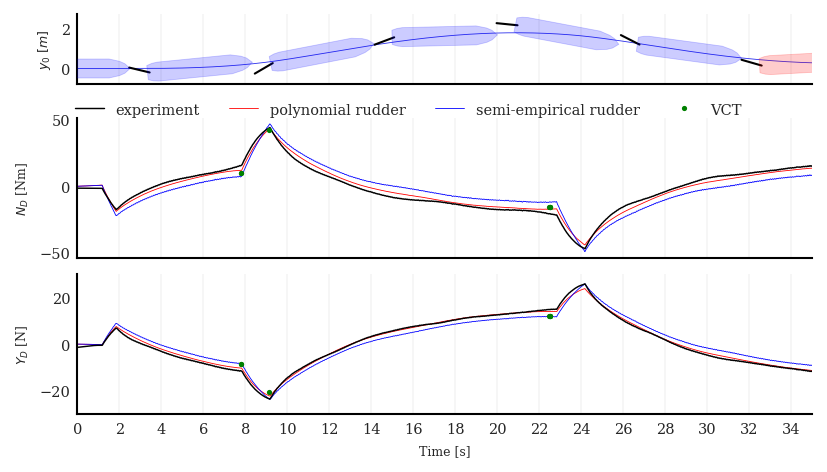

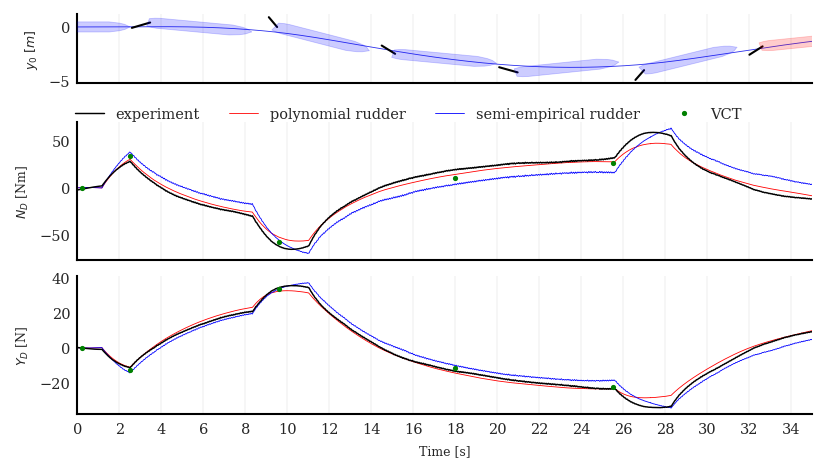

In [218]:
t_maxs = {
    22770 : 35,
    22772 : 35,
    22773 : 35,
}

for id, meta_data in meta_datas.iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha_port']
    keys=['N_D','Y_D']
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units, symbols=symbols);
    
    

    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)

    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.20), ncol=4)


    
    loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
    
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")
    

## Closed loop simulation

[11/13/24 10:29:52] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=683196;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=389681;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=462184;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=227351;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=451716;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=441310;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=611107;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=401806;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=207146;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=198708;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:53] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=356364;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=395513;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:54] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=946881;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=244343;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:55] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=922157;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=435001;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=322596;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=360865;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=410514;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=516203;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=413734;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=769598;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=939266;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=946186;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:56] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=705493;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=491334;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:57] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=964398;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=91744;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:58] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=743779;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=529865;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/13/24 10:29:59] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=619979;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=543588;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

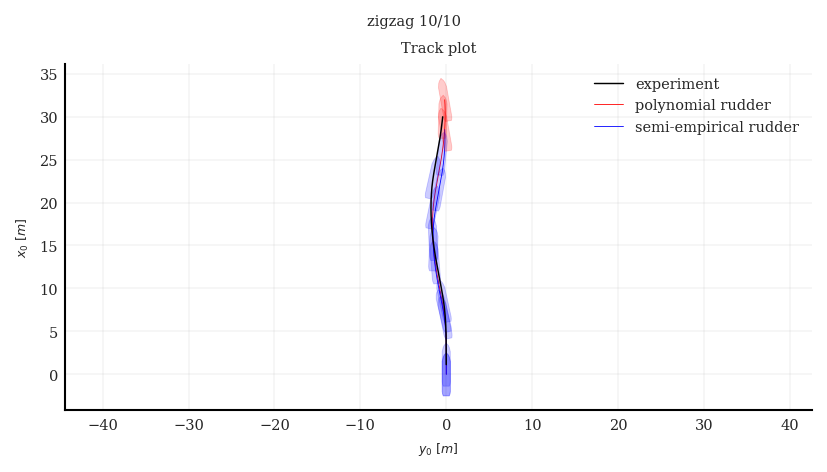

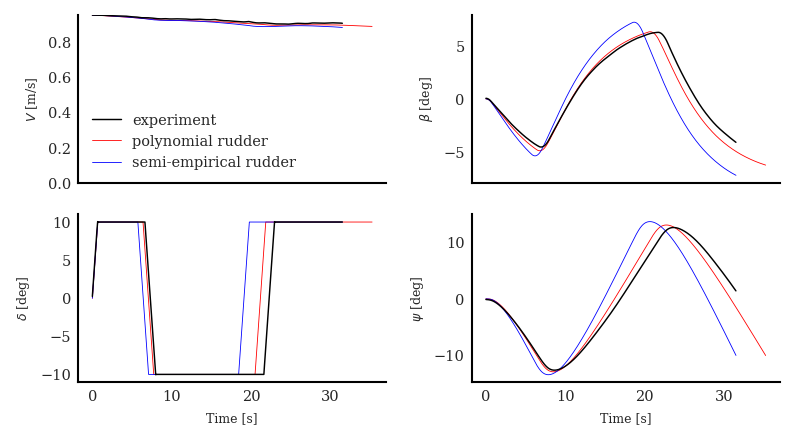

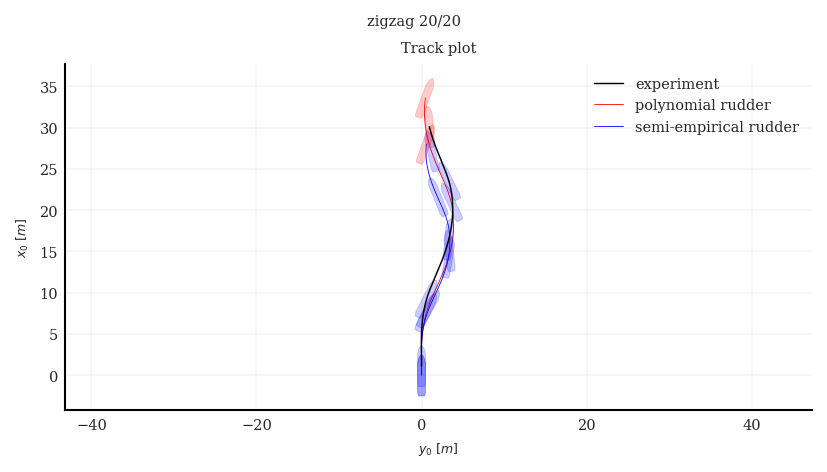

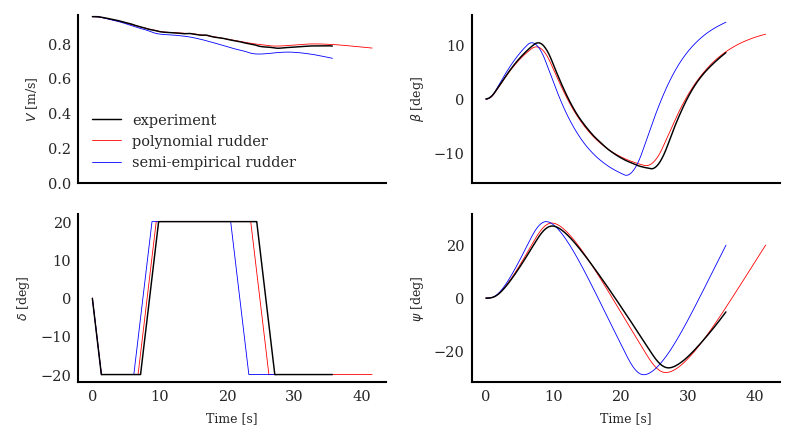

In [219]:
simulations = {}

for angle, group in meta_datas.groupby(by='angle1'):

    fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        try:
            df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        except:
            continue
        
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():
        
            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
        
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()

        if not id in meta_datas.index:
            continue
        
        track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        fig = ax.get_figure()
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta','V','delta'], units=units, styles=styles, ncols=2, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False

In [220]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [221]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[11/13/24 10:30:00] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=692966;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=798475;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=104561;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=337043;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=462199;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=667396;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=161532;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=451080;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/13/24 10:30:01] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=19321;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=477823;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=575145;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=845188;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=90620;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=297090;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=125900;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=210982;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=86977;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=373522;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=97454;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=541853;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=176699;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=77080;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=127479;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=200641;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=725527;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=152011;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=385056;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=150705;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=425523;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=176828;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=743678;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=275284;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [222]:
overshoot_results['angle'] = overshoot_results['angle'].abs()

In [223]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [224]:
overshoot_experiment_mean

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,overshoot_4,t_4,model_name,angle
angle,,,,,,,,,,
10.0,2.401620,9.725009,2.493259,24.790015,2.387873,40.115012,2.286556,56.000006,experiment,10.0
20.0,7.091187,10.944995,6.156289,28.284988,5.767094,46.435001,5.595757,64.589986,experiment,20.0


In [225]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,overshoot_4,t_4
angle,,,,,,,,
10.0,0.189077,0.148491,0.083907,0.070732,0.028753,0.049505,0.064275,0.098999
20.0,0.004095,0.106056,0.181747,0.021212,0.031605,0.162644,0.066145,0.141426


In [226]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].abs()
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [227]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [228]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3,overshoot_4,t_4
0.0,2.878771,8.510000,3.050966,22.760000,22770.0,polynomial rudder,10,NaN,NaN,NaN,NaN
1.0,3.391596,7.870000,3.649122,20.680000,22770.0,semiempirical rudder,10,NaN,NaN,NaN,NaN
2.0,8.286931,9.780000,8.103874,26.730000,22772.0,polynomial rudder,20,NaN,NaN,NaN,NaN
3.0,8.829155,8.940000,8.940551,23.450000,22772.0,semiempirical rudder,20,NaN,NaN,NaN,NaN
10.0,2.401620,9.725009,2.493259,24.790015,NaN,experiment,10,2.387873,40.115012,2.286556,56.000006
20.0,7.091187,10.944995,6.156289,28.284988,NaN,experiment,20,5.767094,46.435001,5.595757,64.589986


In [229]:
def name(row):
    angle = row.name
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f}"
    return name

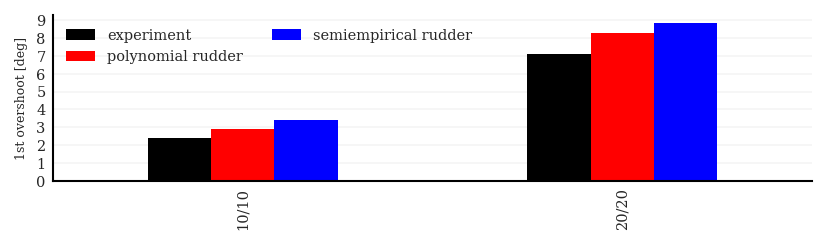

In [230]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=['k','r','b'], ax=ax)
    

ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

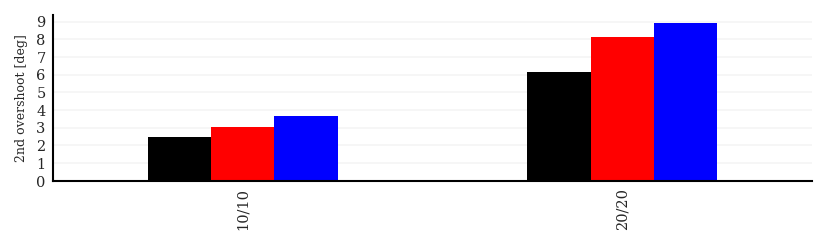

In [231]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=['k','r','b'], ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")